In [1]:
import snntorch as snn
from snntorch import spikegen
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

# Surrogate Gradient Approach

The use of the Heaviside function during the determination of whether or not to spike causes issues during learning because it's derivative, the Dirac Delta Function, tends to be 0 for most values of membrane potential except at the threshold, where it is infinite. This discontinuity is fine during the forward pass, but prevents the use of backpropagation during learning (the *dead neuron problem*). Therefore, during the backward pass, a surrogate term must be used. 

This has interesting implications WRT the robustness of SNNs to adversarial attacks which rely on gradient-based approaches.

The default method in snnTorch is to smooth the Heaviside function with the arctangent function, which does a good job of approximating the intended result.

In [2]:
# Leaky neuron model with a custom function in the backwards pass

class LeakySurrogate(nn.Module):
    def __init__(self, beta, threshold = 1):
        super(LeakySurrogate, self).__init__()
        
        # Initialize decay rate (beta) and threshold
        self.beta = beta
        self.threshold = threshold
        self.spike_gradient = self.ATan.apply
        
    #Set up the forward function
    def forward(self, input_, mem):
        spk = self.spike_gradient((mem - self.threshold)) # Apply the Heaviside function
        reset = (self.beta * spk * self.threshold).detach() # Remove reset from the computational graph
        mem = self.beta * mem + input_ - reset
        return spk, mem
        
    # Backward pass - override Dirac Delta with the derivative of the ArcTan function
    @staticmethod
    class ATan(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            spk = (mem > 0).float() # Heaviside on the forward pass
            ctx.save_for_backward(mem)# Store mem for use in backwards pass
            return spk

        @staticmethod
        def backward(ctx, grad_output):
            (spk, ) = ctx.saved_tensors # Retrieve mem
            grad = 1 / (1 + (np.pi * mem).pow_(2)) * grad_output
            return grad

In [3]:
# Instantiate the neuron defined above...

lif1 = LeakySurrogate(beta = 0.9)

# ...or use the snnTorch implementation

lif1 = snn.Leaky(beta = 0.9)

# Setting up Static MNIST Dataset

In [4]:
# Dataloader arguments

batch_size = 128
data_path = './data/mnist'

dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# Define transform

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0, ), (1, ))
])

mnist_train = datasets.MNIST(data_path, train = True, download = True, transform = transform)
mnist_test = datasets.MNIST(data_path, train = False, download = True, transform = transform)

In [6]:
# Create Dataloaders

train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = True, drop_last = True)

# Defining the Network

In [7]:
# Network architecture

num_inputs = 28 * 28
num_hidden = 100
num_outputs = 10

# Temporal dynamics

num_steps = 25
beta = 0.95

In [8]:
# Define network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta = beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta = beta)
        
    def forward(self, x):
        
        # Initialize the hidden states at t = 0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        
        return torch.stack(spk2_rec, dim = 0), torch.stack(mem2_rec, dim = 0)

# Load the network onto CUDA if available
net = Net().to(device)

# Training the SNN

In [9]:
# Pass data into the network, sum spikes over time, and compare
# the neuron with the highest number of spikes (rate coding) with the target

def print_batch_accuracy(data, targets, train = False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim = 0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())
    
    if train:
        print(f'Train set accuracy for a single minibatch: {acc * 100: .2f}%')
    else:
        print(f'Test set accuracy for a single minibatch: {acc * 100: .2f}%')

def train_printer():
    print(f'Epoch {epoch}, iteration {iter_counter}')
    print(f'Train Set Loss: {loss_hist[counter]: .2f}')
    print(f'Test Set Loss: {test_loss_hist[counter]: .2f}')
    print_batch_accuracy(data, targets, train = True)
    print_batch_accuracy(test_data, test_targets, train = False)
    print('\n')

In [10]:
# Set loss & optimizer

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), lr = 5e-4, betas = (0.9, 0.999))

In [11]:
# Run one iteration of training
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

# Flatten the input vector and pass it into the network

spk_rec, mem_rec = net(data.view(batch_size, -1))

print(mem_rec.size())

torch.Size([25, 128, 10])


The above corresponds to: 25 time steps, 128 samples of data, and 10 output neurons

In [12]:
# Calculate the loss at each time step and sum them across all time steps

loss_val = torch.zeros((1), dtype = dtype, device = device)

# Sum loss at every step

for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)
    
print(f'Training loss: {loss_val.item(): .3f}') 
print_batch_accuracy(data, targets, train = True)

Training loss:  63.607
Train set accuracy for a single minibatch:  12.50%


In [13]:
# Administer a single weight update

# Clear previously stored gradients
optimizer.zero_grad()

# Calculate the gradients
loss_val.backward()

# Weight update
optimizer.step()

Re-running the loss and accuracy caluculation after a single iteration

In [14]:
# Calculate new network outputs using the same data

spk_rec, mem_rec = net(data.view(batch_size, -1))

# Initialize the total loss value

loss_val = torch.zeros((1), dtype = dtype, device = device)

# Sum loss at every step

for step in range(num_steps):
    loss_val += loss(mem_rec[step], targets)
    
print(f'Training loss: {loss_val.item():.3f}')

print_batch_accuracy(data, targets, train = True)

Training loss: 58.071
Train set accuracy for a single minibatch:  12.50%


In [15]:
# Set up training loop

num_epochs = 2
loss_hist = []
test_loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)
    
    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        net.train()
        spk_rec, mem_rec = net(data.view(batch_size, -1))
        
        # Initialize the loss and sum over time
        loss_val = torch.zeros((1), dtype = dtype, device = device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)
            
        # Gradient calculation and weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        # Store loss history for future plotting
        loss_hist.append (loss_val.item())
        
        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)
            
            # Test set forward pass
            test_spk, test_mem = net(test_data.view(batch_size, -1))
            
            # Test set loss
            test_loss = torch.zeros((1), dtype = dtype, device = device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())
            
            # Print train/test loss & accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter += 1

Epoch 0, iteration 0
Train Set Loss:  61.04
Test Set Loss:  56.09
Train set accuracy for a single minibatch:  15.62%
Test set accuracy for a single minibatch:  14.84%


Epoch 0, iteration 50
Train Set Loss:  20.16
Test Set Loss:  16.46
Train set accuracy for a single minibatch:  82.81%
Test set accuracy for a single minibatch:  89.84%


Epoch 0, iteration 100
Train Set Loss:  15.10
Test Set Loss:  15.22
Train set accuracy for a single minibatch:  81.25%
Test set accuracy for a single minibatch:  87.50%


Epoch 0, iteration 150
Train Set Loss:  16.87
Test Set Loss:  10.40
Train set accuracy for a single minibatch:  85.94%
Test set accuracy for a single minibatch:  89.84%


Epoch 0, iteration 200
Train Set Loss:  10.90
Test Set Loss:  12.34
Train set accuracy for a single minibatch:  90.62%
Test set accuracy for a single minibatch:  88.28%


Epoch 0, iteration 250
Train Set Loss:  9.31
Test Set Loss:  8.93
Train set accuracy for a single minibatch:  92.19%
Test set accuracy for a single 

<function matplotlib.pyplot.show(close=None, block=None)>

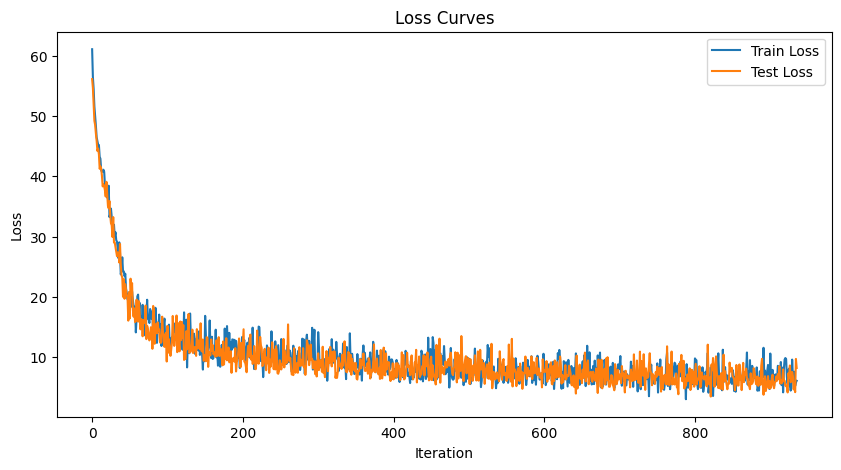

In [16]:
# Plot loss

fig = plt.figure(facecolor = 'w', figsize = (10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title('Loss Curves')
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show

In [17]:
# Assess test set accuracy

total = 0
correct = 0

# drop_last switched to False to keep all samples

test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = True, drop_last = False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        test_spk, _ = net(data.view(data.size(0), -1))
        
        # Calculate total accuracy
        _, predicted = test_spk.sum(dim = 0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

In [18]:
print(f'Total correctly classified test set images: {correct}/{total}')
print(f'Test Set Accuracy: {100 * correct / total: .2f}%')

Total correctly classified test set images: 9212/10000
Test Set Accuracy:  92.12%
